<a href="https://colab.research.google.com/github/Abbta/adlfpae/blob/main/Exercise_7_3_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

The code block below defines a few helper functions to visualize the results. You do not need to touch them.

In [2]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue).

In [3]:

# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

170498071/170498071 [==============================] - 9s 0us/step
images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


(<Figure size 1000x1000 with 100 Axes>, <Axes: >)

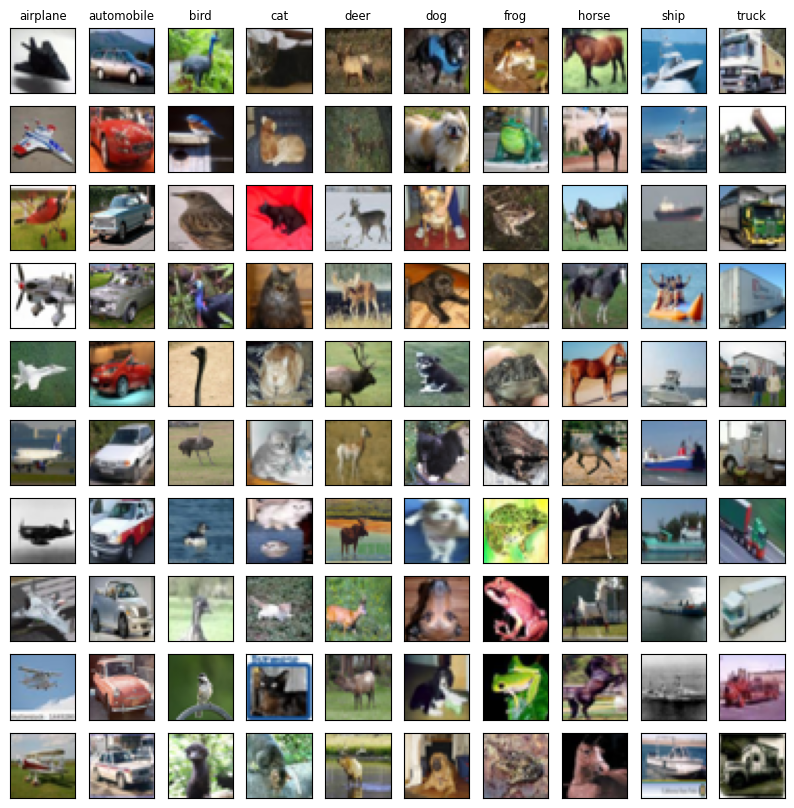

In [ ]:
# Hint: To plot example images, you can use the plot examples function
plot_examples(x_train, y_train)

In [4]:
print(y_test.shape)

(10000, 1)


In [4]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# Hint: normalize the data
x_train_norm = (x_train-np.mean(x_train)) / np.std(x_train)
x_test_norm = (x_test-np.mean(x_test)) / np.std(x_test)

# Hint: use 20% of the training data for validation
x_valid_norm=x_test_norm[8000:]
x_test_norm=x_test_norm[:8000]

### Define dense network

In [5]:
def dense_block(x,n=4, channels=8, convshape=(3,3)):
    xlist=[x]
    for i in range(n):
      xlist.append(layers.Conv2D(channels, convshape, padding="same", activation="relu")(x))
      x=layers.concatenate(xlist[:], axis=-1)
    return x

In [6]:
#Implement the horse example from slide 17 in the notes
x0=tf.keras.Input(shape=(32, 32, 3), name="input")
x=layers.Conv2D(8, kernel_size=(3, 3), padding="valid", activation="relu")(x0)
x=dense_block(x, 4, 16, (4,4))
x=layers.Conv2D(16, kernel_size=(4, 4), padding="valid", activation="relu")(x)
x=layers.MaxPooling2D((2,2), strides=(2,2))(x)

x=dense_block(x, 4, 32, (3,3))
x=layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu")(x)
x=layers.MaxPooling2D((3,3), strides=(3,3))(x)

x=dense_block(x, 4, 64, (2,2))
x=layers.MaxPooling2D((2,2), strides=(2,2))(x)
x=layers.Flatten()(x)
x=layers.Dense(10, activation="softmax")(x)

model = tf.keras.models.Model(
    inputs=[x0],
    outputs=[x],
    name="DenseNet",
)

print(model.summary())

Model: "DenseNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 8)    224         ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 16)   2064        ['conv2d[0][0]']                 
                                                                                                  
 concatenate (Concatenate)      (None, 30, 30, 24)   0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]']        

In [7]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=["accuracy"]
)

model.fit(
    x_train_norm, y_train_onehot,
    batch_size=1000,
    epochs=20, # train at least for 20 epochs
    verbose=1,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
50/50 [==============================] - 49s 719ms/step - loss: 1.9764 - accuracy: 0.2853 - val_loss: 1.6755 - val_accuracy: 0.3915
Epoch 2/20
50/50 [==============================] - 13s 256ms/step - loss: 1.5586 - accuracy: 0.4365 - val_loss: 1.4485 - val_accuracy: 0.4785
Epoch 3/20
50/50 [==============================] - 13s 253ms/step - loss: 1.3427 - accuracy: 0.5205 - val_loss: 1.3159 - val_accuracy: 0.5175
Epoch 4/20
50/50 [==============================] - 13s 252ms/step - loss: 1.2093 - accuracy: 0.5706 - val_loss: 1.2087 - val_accuracy: 0.5630
Epoch 5/20
50/50 [==============================] - 12s 246ms/step - loss: 1.1043 - accuracy: 0.6093 - val_loss: 1.1409 - val_accuracy: 0.6010
Epoch 6/20
50/50 [==============================] - 12s 246ms/step - loss: 1.0235 - accuracy: 0.6394 - val_loss: 1.1023 - val_accuracy: 0.6085
Epoch 7/20
50/50 [==============================] - 12s 248ms/step - loss: 0.9392 - accuracy: 0.6706 - val_loss: 1.0258 - val_accuracy: 0.6375

63/63 [==============================] - 4s 47ms/step
0.68825


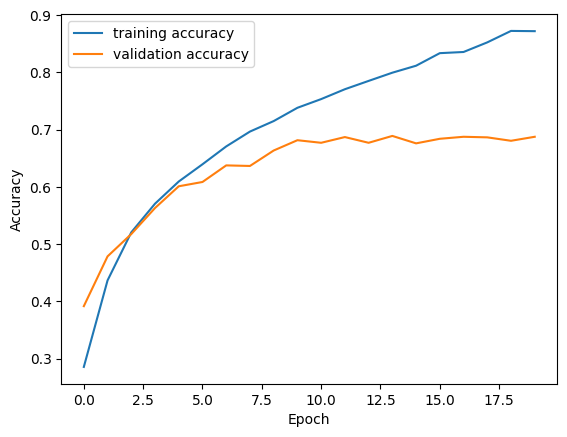

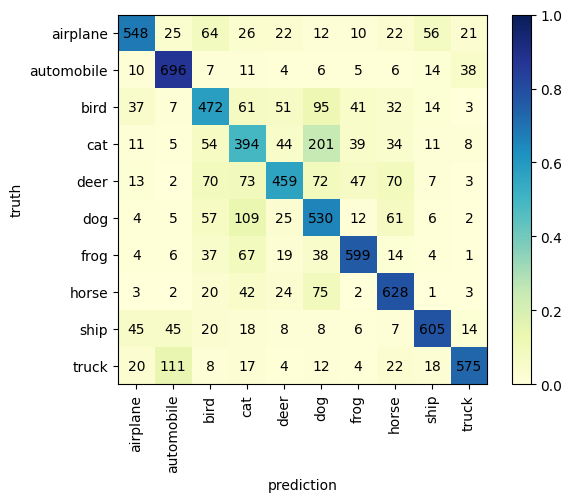

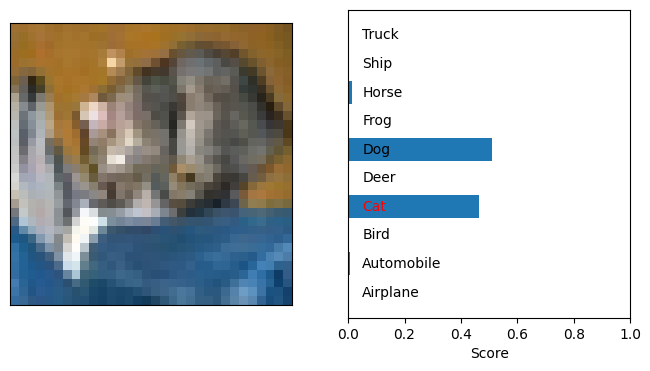

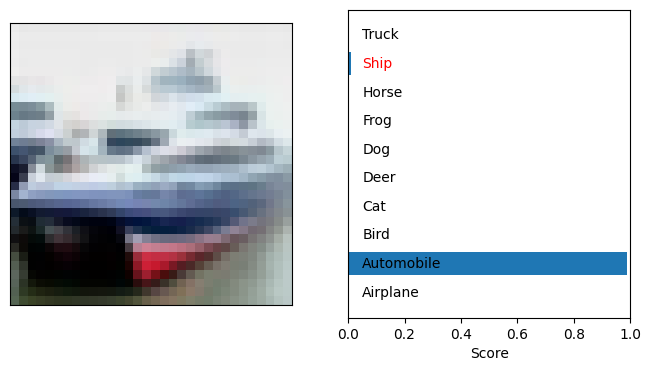

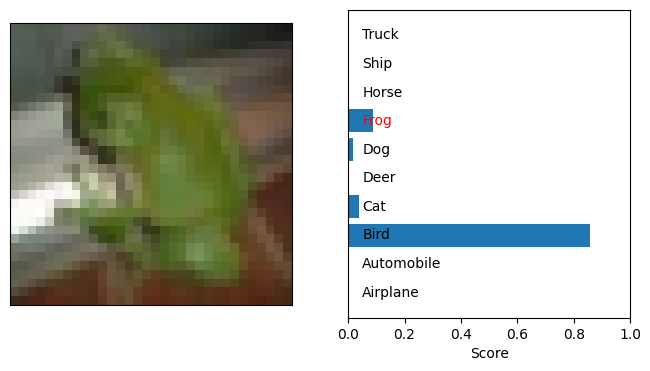

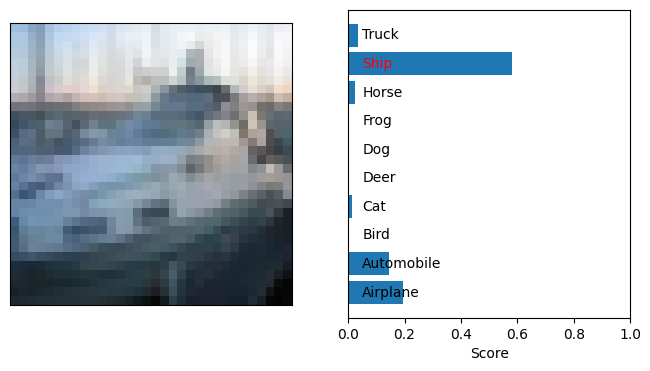

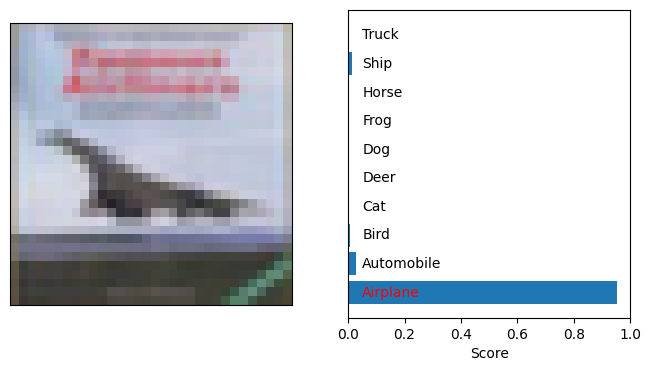

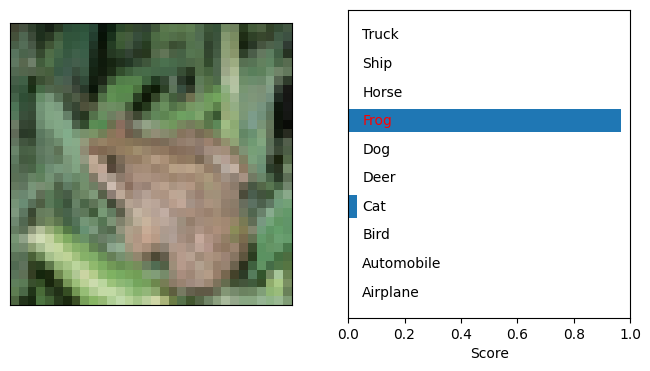

In [8]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

plt.figure()
plt.plot(history["epoch"], history["accuracy"], label="training accuracy")
plt.plot(history["epoch"], history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Hint: this is how you can plot the confusion matrix.
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

#
test_acc=np.mean(np.equal(y_predict_cl, y_test_cl))
print(test_acc)

# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
i0 = np.argwhere(y_predict_cl != y_test_cl)  # misclassified images
i1 = np.argwhere(y_predict_cl == y_test_cl)  # correctly classified images


# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 3 false classifications
for i in i0[0:3,0]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

#Plot correct classifications:
for i in i1[0:3,0]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])


## Note
train accuracy: 87%, validation accuracy: 69%, test accuracy: 72%. Much better test accuracy now=better model with DenseNet. Although it is a bit overfitted (high generalization error), we could use some regularization or similar to improve performance.